In [1]:
%load_ext autoreload
%autoreload 2
!pwd
import os
import sys 
if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../")) 

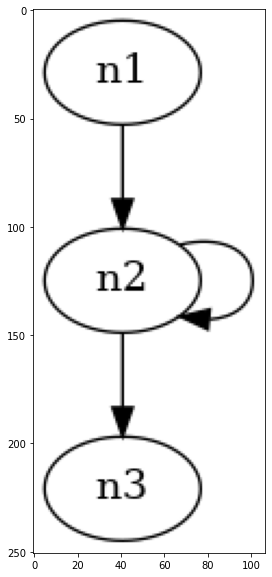

In [2]:
%autoreload 2
import os
import networkx as nx
from rwtools.nemesis.graph.nemesis_node import AbstractNemesisNode
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from rwtools.nemesis.control_flow_graph import ControlFlowGraph
from rwtools.nemesis.graph.utils import equalize_path_lengths
from rwtools.nemesis.graph.utils import to_img

%autoreload 2
from rwtools.nemesis.graph.utils import get_root 
from rwtools.nemesis.graph.balance import balance_branching_point, balance_node_latencies


def to_png(graph, name="temp"):
    out_file = os.path.abspath(f"./{name}.dot")
    nx.drawing.nx_agraph.write_dot(graph, out_file)
    cmd = f"dot -Tpng {out_file} -o {name}.png"
    os.system(cmd)
    img = mpimg.imread(f"{name}.png")
    plt.figure(figsize = (10,10))
    plt.imshow(img)

from rwtools.nemesis.graph.utils import get_root 

G = nx.DiGraph()
n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")

g_nodes = [n1, n2, n3]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)

G.add_edge(n1, n2)
G.add_edge(n2, n3)
G.add_edge(n2, n2)
# G.add_edge(n3, n1)

to_png(G)



# Unwinding the cycle
Unwinding the cycle is fairly straightforward. Take the first and last nodes in the cycle, remove the edge between them, and add a copy of the first node as a child of the last node.  
One difficulty maybe is to correclty define 'first' and 'last' node (difficult because they are in a cycle so there is not first and last node).  

[n2]


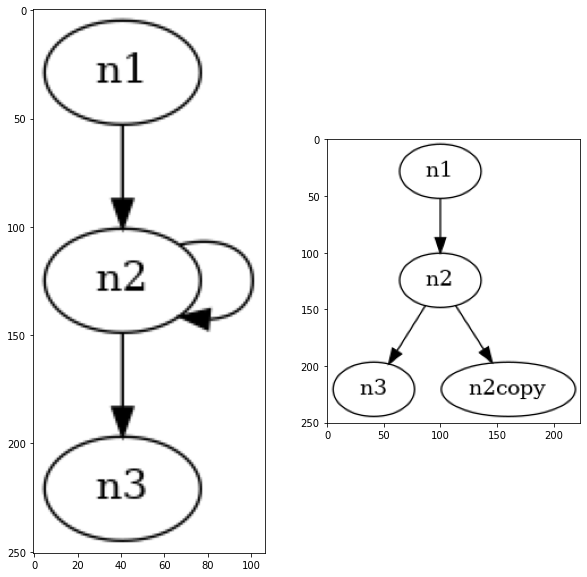

In [3]:
from networkx.algorithms.cycles import simple_cycles
from rwtools.nemesis.graph.utils import get_root, single_source_longest_dag_path_length
import copy 
from rwtools.nemesis.graph.utils import unwind_graph




G = nx.DiGraph()

n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")

g_nodes = [n1, n2, n3]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)

G.add_edge(n1, n2)
G.add_edge(n2, n3)
G.add_edge(n2, n2)

figs, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(to_img(G))

unwind_graph(G)
    
axs[1].imshow(to_img(G))



# Balancing the unwound graph 
During the balancing algorithm we need to take into account that the original node (n2) and it's copy (n2copy) actually represent exactly the same node, and therefore need to contain the exact same latencies (and the same instructions in the concrete graph)   



[n2]
warning, no nop instruction found with latency 3
warning, no nop instruction found with latency 2


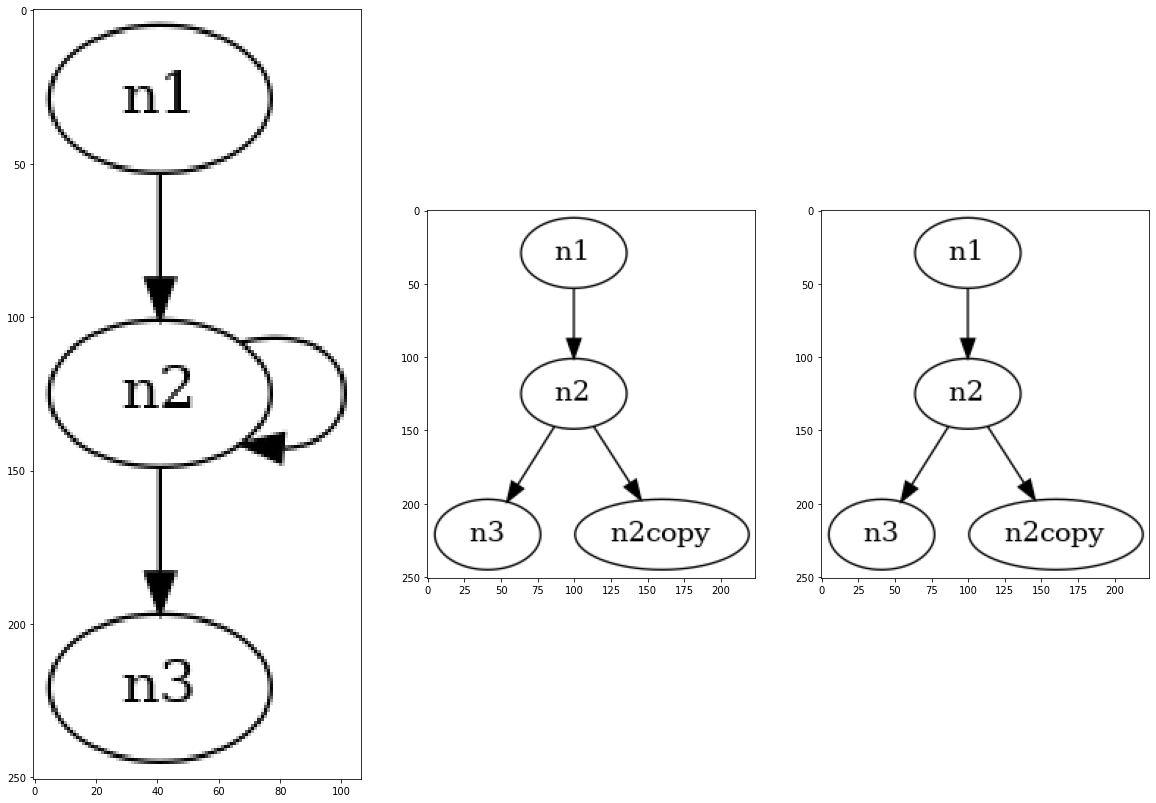

In [4]:
from rwtools.nemesis.graph.balance import balance_branching_point

G = nx.DiGraph()


n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")
n4 = AbstractNemesisNode([2], "n4")

g_nodes = [n1, n2, n3, n4]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)

G.add_edge(n1, n2)
G.add_edge(n2, n2)
G.add_edge(n2, n3)

figs, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(to_img(G))
unwind_graph(G)
axs[1].imshow(to_img(G))
balance_branching_point(G, n2)
axs[2].imshow(to_img(G))


# recreate the cycle (?) 
Not sure how or when this step should be performed, but when a node has its mapped node as a member it's very straigtforward  
Iterate over all nodes, if a node C has a mapped node then remove node C and create an edge from the parent of C to the mapped node   
This is essentially the reverse of what we did to create node C 


[n2]
warning, no nop instruction found with latency 3
warning, no nop instruction found with latency 2


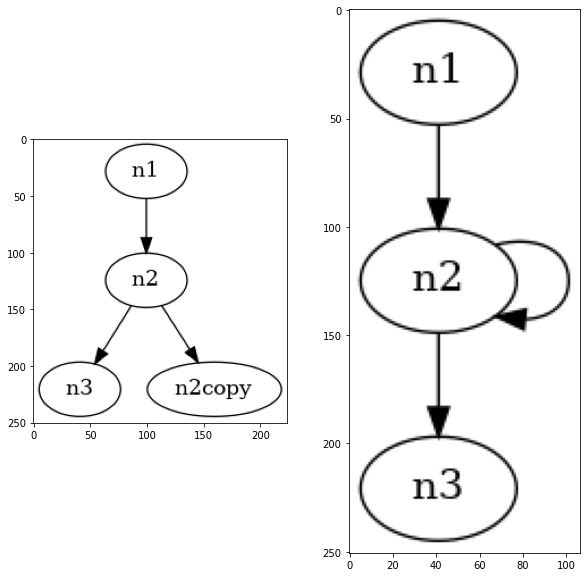

In [5]:
# to prevent iterating over nodes and removing at the same time we first iterate over all the nodes 
# and keep track of the nodes that need to be removed (and their parents) 


G = nx.DiGraph()


n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")
n4 = AbstractNemesisNode([2], "n4")

g_nodes = [n1, n2, n3, n4]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)

G.add_edge(n1, n2)
G.add_edge(n2, n2)
G.add_edge(n2, n3)

figs, axs = plt.subplots(1, 2, figsize=(10, 10))

unwind_graph(G)
balance_branching_point(G, n2)

axs[0].imshow(to_img(G))

mapped_nodes = []
for node in G.nodes: 
    # get the nodes children
    children = G.successors(node)
    for child in children:
        if child.mapped_node is not None: 
            mapped_nodes.append((child, node))             

for mapped_node, parent in mapped_nodes: 
    G.remove_node(mapped_node)
    G.add_edge(parent, mapped_node.mapped_node)

axs[1].imshow(to_img(G))


# Some more complex cases 
e.g. a branching inside a cycle ? 


[n4, n2]
warning, no nop instruction found with latency 3
warning, no nop instruction found with latency 2


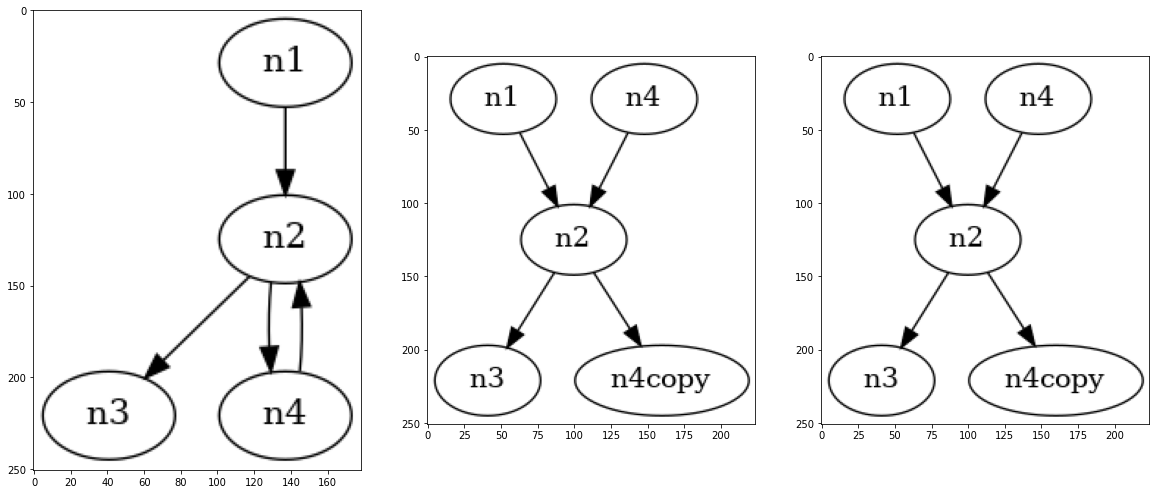

In [6]:

from rwtools.nemesis.graph.utils import to_img 

G = nx.DiGraph()


n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")
n4 = AbstractNemesisNode([2], "n4")

g_nodes = [n1, n2, n3, n4]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)

G.add_edge(n1, n2)
G.add_edge(n2, n3)
G.add_edge(n2, n4)
G.add_edge(n4, n2)

figs, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(to_img(G))
unwind_graph(G)
axs[1].imshow(to_img(G))
balance_branching_point(G, n2)
axs[2].imshow(to_img(G))


warning, no nop instruction found with latency 2
warning, no nop instruction found with latency 1
warning, no nop instruction found with latency 3
warning, no nop instruction found with latency 2


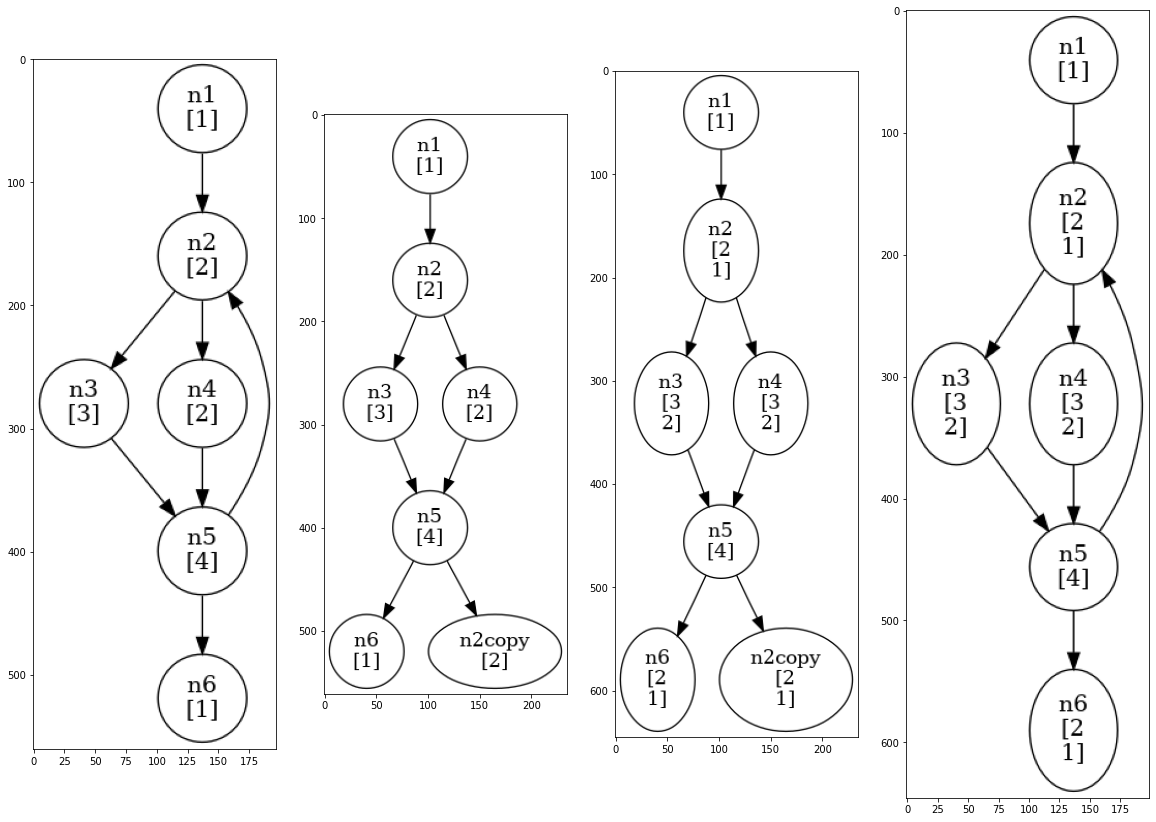

In [32]:

from rwtools.nemesis.graph.utils import to_img 
from rwtools.nemesis.graph.utils import restore_cycles 

G = nx.DiGraph()


n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")
n4 = AbstractNemesisNode([2], "n4")
n5 = AbstractNemesisNode([1], "n5")
n5 = AbstractNemesisNode([4], "n5")
n6 = AbstractNemesisNode([1], "n6")

g_nodes = [n1, n2, n3, n4]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)
G.add_node(n4)
G.add_node(n5)

G.add_edge(n1, n2)
G.add_edge(n2, n3)
G.add_edge(n2, n4)
G.add_edge(n3, n5)
G.add_edge(n4, n5)
G.add_edge(n4, n5)
G.add_edge(n5, n6)
G.add_edge(n5, n2)
# G.add_edge(n4, n2)

figs, axs = plt.subplots(1, 4, figsize=(20, 20))

axs[0].imshow(to_img(G))
unwind_graph(G)
axs[1].imshow(to_img(G))

balance_branching_point(G, n2)
axs[2].imshow(to_img(G))
restore_cycles(G)
axs[3].imshow(to_img(G))


warning, no nop instruction found with latency 2
warning, no nop instruction found with latency 1
warning, no nop instruction found with latency 4
warning, no nop instruction found with latency 2
warning, no nop instruction found with latency 1
warning, no nop instruction found with latency 4
warning, no nop instruction found with latency 3
warning, no nop instruction found with latency 2


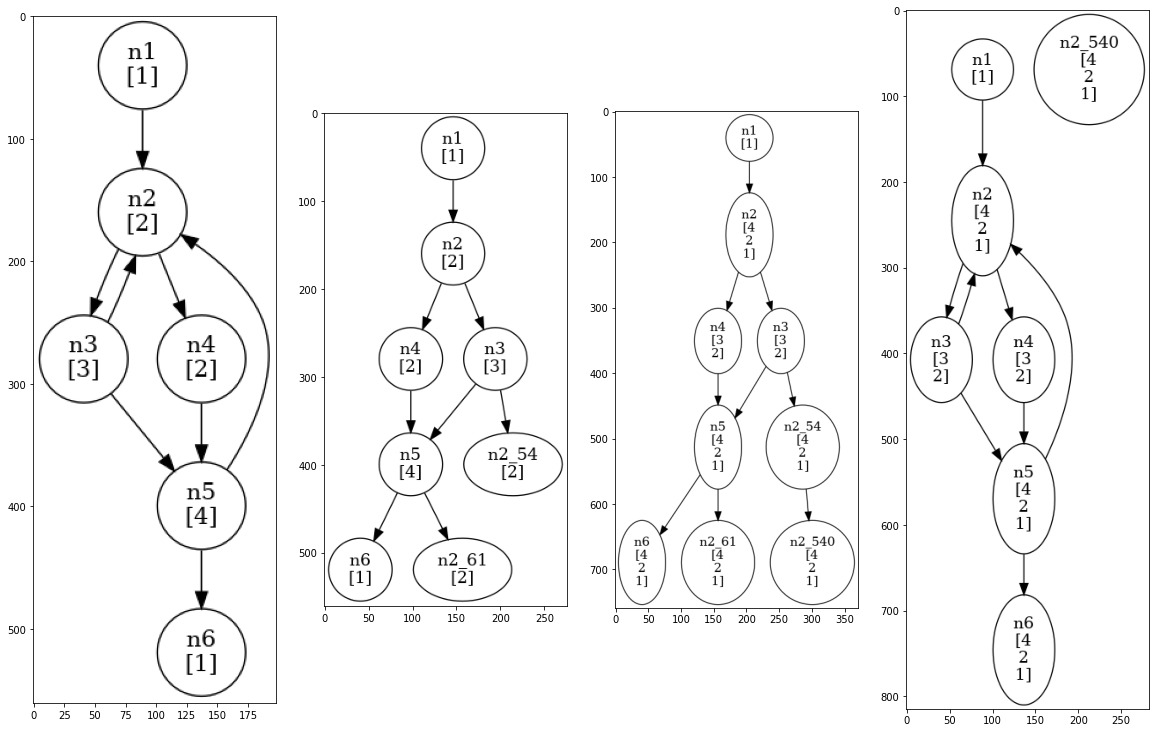

In [66]:

from rwtools.nemesis.graph.utils import to_img 
from rwtools.nemesis.graph.utils import restore_cycles 

G = nx.DiGraph()


n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")
n4 = AbstractNemesisNode([2], "n4")
n5 = AbstractNemesisNode([1], "n5")
n5 = AbstractNemesisNode([4], "n5")
n6 = AbstractNemesisNode([1], "n6")

g_nodes = [n1, n2, n3, n4]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)
G.add_node(n4)
G.add_node(n5)

G.add_edge(n1, n2)
G.add_edge(n2, n3)
G.add_edge(n2, n4)
G.add_edge(n3, n5)
G.add_edge(n4, n5)
G.add_edge(n4, n5)
G.add_edge(n5, n6)
G.add_edge(n5, n2)
G.add_edge(n3, n2)

figs, axs = plt.subplots(1, 4, figsize=(20, 20))

axs[0].imshow(to_img(G))
unwind_graph(G)
axs[1].imshow(to_img(G))
balance_branching_point(G, n2)
axs[2].imshow(to_img(G))
restore_cycles(G)
axs[3].imshow(to_img(G))


In [ ]:
G = nx.DiGraph()


n1 = AbstractNemesisNode([1], "n1")
n2 = AbstractNemesisNode([2], "n2")
n3 = AbstractNemesisNode([3], "n3")
n4 = AbstractNemesisNode([2], "n4")
n5 = AbstractNemesisNode([1], "n5")
n5 = AbstractNemesisNode([4], "n5")
n6 = AbstractNemesisNode([1], "n6")

g_nodes = [n1, n2, n3, n4]

G.add_node(n1)
G.add_node(n2)
G.add_node(n3)
G.add_node(n4)
G.add_node(n5)
